In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import sparse
import itertools

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='3:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(40)

/glade/work/djk2120/miniconda3/envs/trendy-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39114 instead
  f"Port {expected} is already in use.\n"


In [4]:
client.cluster

In [5]:
def time_set_mid(ds, time_name):
    """
    set ds[time_name] to midpoint of ds[time_name].attrs['bounds'], if bounds attribute exists
    type of ds[time_name] is not changed
    ds is returned
    """

    if 'bounds' not in ds[time_name].attrs:
        return ds

    # determine units and calendar of unencoded time values
    if ds[time_name].dtype == np.dtype('O'):
        units = 'days since 0000-01-01'
        calendar = 'noleap'
    else:
        units = ds[time_name].attrs['units']
        calendar = ds[time_name].attrs['calendar']

    # construct unencoded midpoint values, assumes bounds dim is 2nd
    tb_name = ds[time_name].attrs['bounds']
    if ds[tb_name].dtype == np.dtype('O'):
        tb_vals = cftime.date2num(ds[tb_name].values, units=units, calendar=calendar)
    else:
        tb_vals = ds[tb_name].values
    tb_mid = tb_vals.mean(axis=1)

    # set ds[time_name] to tb_mid
    if ds[time_name].dtype == np.dtype('O'):
        ds[time_name] = cftime.num2date(tb_mid, units=units, calendar=calendar)
    else:
        ds[time_name] = tb_mid

    return ds

In [41]:
#from Deepak
def to_sparse(data, vegtype, jxy, ixy, shape):
    """ Takes an input numpy array and converts it to a sparse array."""
    import itertools

    import sparse

    codes = zip(vegtype, jxy - 1, ixy - 1)

    # some magic from https://github.com/pydata/xarray/pull/5577
    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        indexes = codes
    else:
        sizes = list(itertools.product(*[range(s) for s in data.shape[:-1]]))
        tuple_indexes = itertools.product(sizes, codes)
        indexes = map(lambda x: list(itertools.chain(*x)), tuple_indexes)

    return sparse.COO(
        coords=np.array(list(indexes)).T,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=-99999
    )


def convert_pft_variables_to_sparse(dataset):
    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = vegtype.max().load().item()
    # expected shape of sparse arrays (excludes time)
    output_sizes = {
        "pft": npft + 1,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["pft", "lat", "lon"]],
            exclude_dims=set(("pft",)),  # changes size
            dask="parallelized",
            kwargs=dict(shape=tuple(output_sizes.values())),
            dask_gufunc_kwargs=dict(
                meta=sparse.COO([],fill_value=-99999),
                output_sizes=output_sizes,
            ),  # lets dask know that we are changing from numpy to sparse
            #output_dtypes=[pfts[var].dtype],
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["pft"] = np.arange(result.sizes["pft"])
    return result

### START HERE

In [54]:
file = '/glade/u/home/djk2120/ctsm_trendy_2021/TRENDY2021_f09_S0_constant.clm2.h1.TLAI.170001-202012.nc'

In [55]:
ds = time_set_mid(
    xr.open_dataset(
        file,
        decode_times=True,
        chunks={"time": 100},
        
    ),
    "time",
)

In [56]:
pft = convert_pft_variables_to_sparse(ds)

In [57]:
%%time
outdir='./'
outfile = outdir+datavar+'_'+str(pp).zfill(2)+'.nc'
datavar='TLAI';pp=1
x = pft[datavar].isel(pft=pp).compute()
x = x.copy(data=x.data.todense())
x.to_netcdf(outfile)

CPU times: user 2.37 s, sys: 1.7 s, total: 4.06 s
Wall time: 31 s


In [60]:
ds_pft01 = xr.open_dataset(outfile)

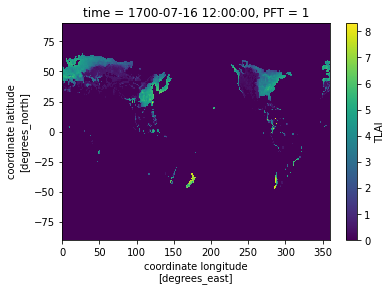

In [61]:
## would like to have this contain a fill_value=-99999
## e.g. all oceans and many land gridcells should be NaN instead of 0
ds_pft01.TLAI.isel(time=6).plot()

### extra stuff, not needed for testing

In [ ]:
%%time
pft = convert_pft_variables_to_sparse(ds)
pft = pft.rename({'lat':'latitude','pft':'PFT','lon':'longitude'})

In [ ]:
topdir   = '/glade/campaign/asp/djk2120/trendy2021/'
firstbit = 'TRENDY2021_f09_'
lastbit  = '.clm2.h1.'
years    = '.170001-202012.nc'

hkey={}
hkey['S0']= firstbit+'S0_constant'+lastbit
hkey['S1']= firstbit+'S1_CO2'+lastbit
hkey['S2']= firstbit+'S2_CO2Climate'+lastbit
hkey['S3']= firstbit+'S3_CO2ClimateLUC'+lastbit

def get_file(sim,datavar):
    datadir = topdir + sim + '/lnd/proc/tseries/month_1/'
    
    file = datadir+hkey[sim]+datavar+years
    
    return file
    

In [34]:
ds = xr.open_dataset('TLAI_01.nc')

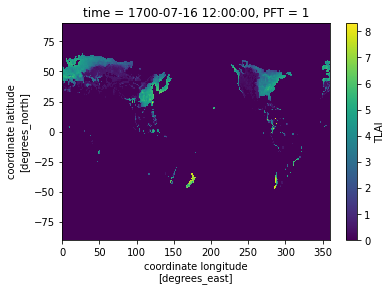

In [37]:
ds.TLAI.isel(time=6).plot()

In [222]:
lp = xr.open_dataset('/glade/u/home/djk2120/ctsm_trendy_2021/LPJ-GUESS_S0_laipft.nc')

In [223]:
lp

<xarray.Dataset>
Dimensions:    (PFT: 26, longitude: 720, latitude: 360, time: 3852)
Coordinates:
  * PFT        (PFT) int32 1 2 3 4 5 6 7 8 9 10 ... 18 19 20 21 22 23 24 25 26
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) object 1700-01-16 00:00:00 ... 2020-12-16 00:00:00
Data variables:
    laipft     (time, latitude, longitude, PFT) float32 ...
Attributes:
    title:        LPJ-GUESS output: S0 scenario
    institution:  IMK-IFU, Karlsruhe Institute of Technology, Garmisch-Parten...
    contact:      Peter Anthoni, peter.anthoni@kit.edu
    version:      v1
    PFT:          1:Boreal needleleaf evergreen (BNE), 2:Boreal shade-intoler...

CPU times: user 2.04 s, sys: 894 ms, total: 2.93 s
Wall time: 43 s


In [22]:
%%time


CPU times: user 205 ms, sys: 157 ms, total: 362 ms
Wall time: 343 ms


In [24]:
%%time


CPU times: user 92.8 ms, sys: 282 ms, total: 375 ms
Wall time: 532 ms


### check if the two methods match

In [38]:
f1='/glade/scratch/djk2120/trendy_pft/CLM5.0_S0_lai_PFT_02.nc'
f2=outdir+datavar+'_'+str(pp).zfill(2)+'.nc'
f2

'/glade/campaign/asp/djk2120/trendy2021/nbfiles/S0/TLAI_01.nc'

In [54]:
ds1 = xr.open_dataset(f1)
ds1

<xarray.Dataset>
Dimensions:     (lat: 192, lon: 288, time: 3852)
Coordinates:
  * lat         (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1700-02-01 00:00:00 ... 2021-01-01 00:00:00
Data variables:
    lai_PFT_02  (time, lat, lon) float32 ...
Attributes:
    pft_name_02:  needleleaf_evergreen_temperate_tree

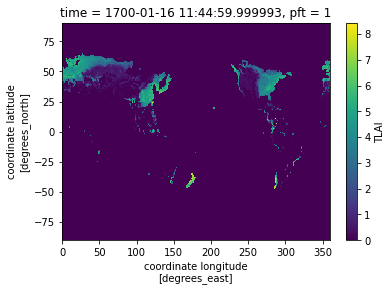

In [48]:
ds2 = xr.open_dataset(f2)
ds2.fillna(-99999).TLAI.isel(time=0).plot()

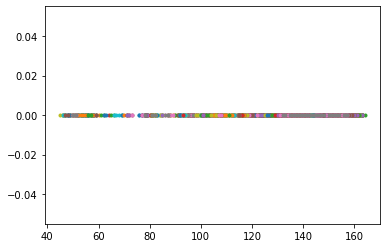

In [47]:
plt.plot(ds1.lai_PFT_02.isel(time=0)-ds2.TLAI.isel(time=0),'.');

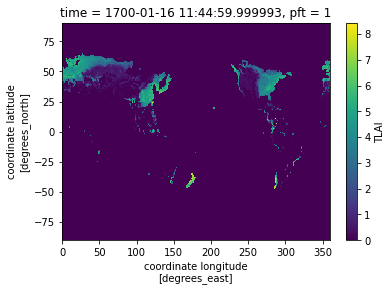

In [43]:
.plot()

In [173]:
### configure some variable info

In [8]:
cfs=dict()
cfs['evapotranspft']=1
cfs['transpft']=1
cfs['evapo']=1
cfs['albedopft']=1
cfs['snow_depthpft']=1
cfs['shflxpft']=1
cfs['rnpft']=1
cfs['cVegpft']=1e-3
cfs['gpppft']=1e-3
cfs['npppft']=1e-3
cfs['nbppft']=1e-3
cfs['laipft']=1
cfs['tskinpft']=1
cfs['theightpft']=1

clmvars = dict()
clmvars['evapotranspft']=['FCTR','FCEV','FGEV']
clmvars['transpft']='FCTR'
clmvars['evapo']='FGEV'
clmvars['albedopft']='na'
clmvars['snow_depthpft']='SNOWDP'
clmvars['shflxpft']='FSH'
clmvars['rnpft']='Rnet'
clmvars['cVegpft']='TOTVEGC'
clmvars['gpppft']='GPP'
clmvars['npppft']='NPP'
clmvars['nbppft']='NBP'
clmvars['laipft']='TLAI'
clmvars['tskinpft']='TV'
clmvars['theightpft']='HTOP'


df=pd.read_csv('trendy_variables.csv',skiprows=8)
long_name = []
for index, row in df.iterrows():
    ln = row['long name']
    if type(ln) is str:
        long_name.append(ln)
    else:
        long_name.append('na')
df['long_name']=long_name

df['units'] = df['units ']
df['outvar'] = df['output variable name ']

ix1 = df.priority==1
ix2 = df.long_name.str.startswith('Vegtype')
ix3 = (df.outvar=='tskinpft')|(df.outvar=='theightpft')
ix  = (ix1)&(ix2)|(ix3)

cols = ['outvar','long_name','units','frequency']
varinfo = df[cols][ix]
varinfo['cf']     = [cfs[v]     for v in varinfo.outvar.values]
varinfo['clmvar'] = [clmvars[v] for v in varinfo.outvar.values]


In [9]:
varinfo

,outvar,long_name,units,frequency,cf,clmvar
10,evapotranspft,Vegtype level evapotranspiration,W m-2,monthly,1.000,"[FCTR, FCEV, FGEV]"
11,transpft,Vegtype level transpiration,W m-2,monthly,1.000,FCTR
12,evapo,Vegtype level Soil evaporation,W m-2,monthly,1.000,FGEV
13,albedopft,Vegtype level Broadband Albedo,fraction,monthly,1.000,na
14,snow_depthpft,Vegtype level snow depth or snow water equival...,m m-2,monthly,1.000,SNOWDP
15,shflxpft,Vegtype level sensible heat flux,W m-2,monthly,1.000,FSH
16,rnpft,Vegtype level net radiation,W m-2,monthly,1.000,Rnet
23,cVegpft,Vegtype level Carbon in Vegetation,kg m-2,annual,0.001,TOTVEGC
34,gpppft,Vegtype level GPP,kg m-2 s-1,monthly,0.001,GPP
35,npppft,Vegtype level NPP,kg m-2 s-1,monthly,0.001,NPP
